# Overview

On the "portuguese_subscribed_clients" notebook I made some EDA to understand the dataset a bit and get some information to help bank's marketing team to improve their campaign.

In this notebook, I will create a solution to predict if a client will subscribe a term deposit or not. Since marketing is an area that usually spend a lot of money to increase sales, subscriptions, etc., this algorithm can substantially improve this bank financial spending to bring more people as a term subscriber.

So, let's do this!

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import calendar

In [2]:
df = pd.read_csv('dataset/bank-full.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


On the EDA notebook I mentioned that
"If we interpret contact unknown as a missing data, 29% of this column will be missing. This data is from 2008 and 2010 and at that time, Portugal population was around 10,5 million with around [13 million mobile phone subscribers](https://www.theglobaleconomy.com/Portugal/Mobile_phone_subscribers/) (some users might had more than one line?). So, I will change "unknown" for cellular here."

I will also transform 'pdays' in a categorical column and 'month' to values

In [3]:
#mapping unknown values to cellular
df['contact'] = df.contact.apply(lambda x: 'cellular' if x=='unknown' else x)

# creating new column to transform pdays in categories
df['campaign_contact'] = df.pdays.apply(lambda x: 'never_contacted' if x<0 else 'already_contacted')

#month to number
abbr_to_num = {name.lower(): num for num, name in enumerate(calendar.month_abbr) if num}
df['month'] = df['month'].apply(lambda x: abbr_to_num[x])

converting output data to numeric

In [4]:
df['y'] = df['y'].map({'no':0,
                       'yes':1})

And the column poutcome have 82% of "missing data" (unknown) I will drop it and will not use on the model.

In [5]:
df.drop(['poutcome', 'pdays'], axis=1, inplace=True)

In [6]:
df.describe()

,age,balance,day,month,duration,campaign,previous,y
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,6.144655,258.163080,2.763841,0.580323,0.116985
std,10.618762,3044.765829,8.322476,2.408034,257.527812,3.098021,2.303441,0.321406
min,18.000000,-8019.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,33.000000,72.000000,8.000000,5.000000,103.000000,1.000000,0.000000,0.000000
50%,39.000000,448.000000,16.000000,6.000000,180.000000,2.000000,0.000000,0.000000
75%,48.000000,1428.000000,21.000000,8.000000,319.000000,3.000000,0.000000,0.000000
max,95.000000,102127.000000,31.000000,12.000000,4918.000000,63.000000,275.000000,1.000000


In [7]:
df.dtypes

age                  int64
job                 object
marital             object
education           object
default             object
balance              int64
housing             object
loan                object
contact             object
day                  int64
month                int64
duration             int64
campaign             int64
previous             int64
y                    int64
campaign_contact    object
dtype: object

Taking a look at cardinality for categorical columns

In [8]:
object_columns = df.loc[:, df.dtypes == object].columns
for column in object_columns:
    unique_data = df[column].unique().tolist()
    print(f'Column {column} have {len(unique_data)} unique values')

Column job have 12 unique values
Column marital have 3 unique values
Column education have 4 unique values
Column default have 2 unique values
Column housing have 2 unique values
Column loan have 2 unique values
Column contact have 2 unique values
Column campaign_contact have 2 unique values


In [9]:
# split train test data
from sklearn.model_selection import train_test_split

X = df.drop('y', axis=1)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=12, stratify=y)
print("X_train size: ", X_train.shape)
print("X_train size: ", y_train.shape)
print("X_train size: ", X_test.shape)
print("X_train size: ", y_test.shape)


X_train size:  (31647, 15)
X_train size:  (31647,)
X_train size:  (13564, 15)
X_train size:  (13564,)


Since all columns have low cardinality (unique values), I will encode all columns and train a model with every data available

In [10]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

# Modelo 1 - RandomForest with default hiperparameters

* accuracy = 0.88
* AUC = 0.523
* Confusion matrix [[11936, 54

                   1493, 81]]

In [11]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=12)
model.fit(X_train_encoded, y_train)

RandomForestClassifier(random_state=12)

              precision    recall  f1-score   support

          no       0.89      1.00      0.94     11977
         yes       0.53      0.04      0.07      1587

    accuracy                           0.88     13564
   macro avg       0.71      0.52      0.51     13564
weighted avg       0.84      0.88      0.84     13564

------
Area sob a curva AUC: 0.517


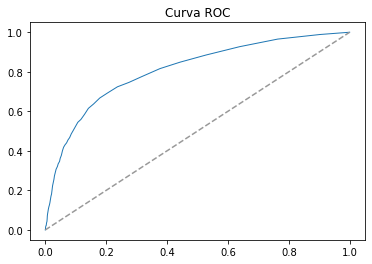

In [20]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, plot_roc_curve
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

y_predicted = model.predict(X_test_encoded)
y_predicted_prob = model.predict_proba(X_test_encoded)[:,1]
fpr, tpr, threshold = roc_curve(y_test.values, y_predicted_prob)
roc_auc = roc_auc_score(y_test, y_predicted)

print(classification_report(y_test, y_predicted, target_names=['no','yes']))
print('------')
print('Area sob a curva AUC: {:.03f}'.format(roc_auc))

plt.plot(fpr, tpr, lw=1)
#plot_roc_curve(model, X_test_encoded, y_test)
plt.plot([0,1],[0,1], '--', color=(0.6, 0.6, 0.6), label="sorte")
plt.title("Curva ROC", fontsize=12) 

plt.show()


In [21]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, y_predicted)
cnf_matrix

array([[11921,    56],
       [ 1525,    62]], dtype=int64)

# Model 2 - Hyperparameters optimize with skopt

* accuracy = 0.88
* AUC = 0.824
* Confusion matrix [[11947,    30

                   1543,44]]
                   
                   
After optimize hyperparameters our model improve on no subscribers but was worse on term deposits.

In [22]:
from skopt import gp_minimize

def train_model(params):
    n_estimators = params[0]
    criterion = params[1]
    max_depth = params[2]
    min_samples_leaf = params[3]
    min_samples_split = params[4]
    
    model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, min_samples_split=min_samples_split,
                                   max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=12)
    
    model.fit(X_train_encoded, y_train)
    Y_predicted = model.predict_proba(X_test_encoded)[:, 1]
    
    return - roc_auc_score(y_test, Y_predicted)

In [23]:
space = [[100, 150, 200, 250, 300, 350, 400, 450, 500],
         ['gini', 'entropy'], 
         [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
         [1, 2, 4],
         [2, 5, 10]]


In [24]:
results = gp_minimize(train_model, space, random_state=12, verbose=1, n_calls=30, n_random_starts=10)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 6.7577
Function value obtained: -0.7755
Current minimum: -0.7755
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.2526
Function value obtained: -0.7726
Current minimum: -0.7755
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 13.8536
Function value obtained: -0.7768
Current minimum: -0.7768
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 6.4186
Function value obtained: -0.7759
Current minimum: -0.7768
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 61.8454
Function value obtained: -0.8233
Current minimum: -0.8233
Iteration No: 6 started

In [25]:
results.x

[450, 'gini', 100, 1, 2]

              precision    recall  f1-score   support

          no       0.89      1.00      0.94     11977
         yes       0.59      0.03      0.05      1587

    accuracy                           0.88     13564
   macro avg       0.74      0.51      0.50     13564
weighted avg       0.85      0.88      0.83     13564

------
Area sob a curva AUC: 0.824


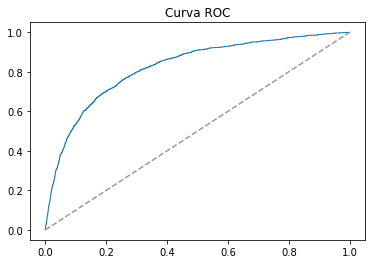

In [26]:
best_model = RandomForestClassifier(n_estimators=450, criterion='gini', max_depth=100,
                                    min_samples_leaf=1, min_samples_split=2, random_state=12)
    
best_model.fit(X_train_encoded, y_train)
y_predicted = best_model.predict(X_test_encoded)
y_predicted_prob = best_model.predict_proba(X_test_encoded)[:, 1]
fpr, tpr, threshold = roc_curve(y_test.values, y_predicted_prob)
roc_auc = roc_auc_score(y_test, y_predicted_prob)

print(classification_report(y_test, y_predicted, target_names=['no','yes']))
print('------')
print('Area sob a curva AUC: {:.03f}'.format(roc_auc))

plt.plot(fpr, tpr, lw=1)
#plot_roc_curve(best_model, X_test_encoded, y_test)
plt.plot([0,1],[0,1], '--', color=(0.6,0.6,0.6), label="sorte")
plt.title("Curva ROC", fontsize=12)

plt.show()


In [27]:
cnf_matrix = confusion_matrix(y_test, y_predicted)
cnf_matrix

array([[11947,    30],
       [ 1543,    44]], dtype=int64)

# Test Upsample


Using upsample we could boost recall for positive class but with a small decrease on the negative class. Also, this increased false negatives a bit but improve true positives considerable.

In [29]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 14)
X_train_3, y_train_3 = smote.fit_sample(X_train_encoded, y_train)

              precision    recall  f1-score   support

          no       0.90      0.98      0.94     11977
         yes       0.57      0.17      0.26      1587

    accuracy                           0.89     13564
   macro avg       0.73      0.58      0.60     13564
weighted avg       0.86      0.89      0.86     13564

------
Area sob a curva AUC: 0.788


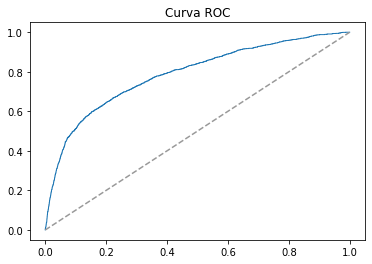

In [36]:
best_model_s = RandomForestClassifier(n_estimators=450, criterion='gini', max_depth=100,
                                      min_samples_leaf=1, min_samples_split=2, random_state=12)
    
best_model_s.fit(X_train_3, y_train_3)
y1_predicted = best_model_s.predict(X_test_encoded)
y1_predicted_prob = best_model_s.predict_proba(X_test_encoded)[:, 1]
fpr, tpr, threshold = roc_curve(y_test.values, y1_predicted_prob)
roc_auc = roc_auc_score(y_test, y1_predicted_prob)

print(classification_report(y_test, y1_predicted, target_names=['no','yes']))
print('------')
print('Area sob a curva AUC: {:.03f}'.format(roc_auc))

plt.plot(fpr, tpr, lw=1)
#plot_roc_curve(best_model_s, X1_test_encoded, y1_test)
plt.plot([0,1],[0,1], '--', color=(0.6,0.6,0.6), label="sorte")
plt.title("Curva ROC", fontsize=12)

plt.show()

In [37]:
cnf_matrix = confusion_matrix(y_test, y1_predicted)
cnf_matrix

array([[11775,   202],
       [ 1320,   267]], dtype=int64)

# Testing with LightGBM

So far, this is our best model. With upsampling techniques the classification report show us increase in almost all metrics and an accuracy of 90% but, precision and f1 also show us improvement. So, this could be a model to put at production maybe in an app in heroku or any cloud this bank want to subscribe. 

Then, marketing team coulds create a csv with users information about:
* job
* gender
* marital
* default loan
* housing loan
* contact - should be cellular or telephone, i.e. device the user will be contacted
* day - day number the contact will be done
* month - month the contact will be done
* duration - estimated amount of seconds the call will last
* campaign - should be 0 if first contact with client
* previous - number of contact the bank usually do with a client - if prospecting clients this should be zero

This csv could be uploaded to the app on heroku and the app export a prediction if a client will do a deposit or not. This could improve further marketing campaigns by a lot, since the user will be targeted and will be qualified. Instead waste time calling everyone, the bank can choose users more likely to do a deposit.

In [70]:
from skopt import gp_minimize, dummy_minimize
from lightgbm import LGBMClassifier

def train_model_lgbm(params):
    #n_estimators = params[0]
    num_leaves = params[0]
    min_child_samples = params[1]
    subsample = params[2]
    colsample_bytree = params[3]
    learning_rate = params[4]
    n_estimators = params[5]
    
    model = LGBMClassifier(n_estimators=n_estimators, num_leaves=num_leaves, min_child_samples=min_child_samples, subsample_freq=1,
                           subsample=subsample, colsample_bytree=colsample_bytree, learning_rate=learning_rate, random_state=12)
    
    model.fit(X_train_encoded, y_train)
    Y_predicted = model.predict_proba(X_test_encoded)[:, 1]
    
    return - roc_auc_score(y_test, Y_predicted)

space_lgbm = [(2, 128, 2), #num_leaves
              (5, 100), #min_child_samples
              (0.05, 1.0), #subsample
              (0.1, 1.0), #colsample_bytree
              (1e-3, 1e-1, 'log-uniform'), #learning_rate
              [100, 150, 200, 250, 300, 350, 400, 450, 500] #n_estimators
             ]

resultado_lgbm = dummy_minimize(train_model_lgbm, space_lgbm, random_state=12, verbose=1, n_calls=30)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 7.6006
Function value obtained: -0.8647
Current minimum: -0.8647
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.7608
Function value obtained: -0.7435
Current minimum: -0.8647
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.1686
Function value obtained: -0.7586
Current minimum: -0.8647
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.9961
Function value obtained: -0.7514
Current minimum: -0.8647
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.2960
Function value obtained: -0.7244
Current minimum: -0.8647
Iteration No: 6 started. 

In [71]:
resultado_lgbm.x

[128, 7, 0.5570524237112829, 0.11311746623687771, 0.06878504348963209, 500]

              precision    recall  f1-score   support

          no       0.91      0.98      0.94     11977
         yes       0.65      0.26      0.38      1587

    accuracy                           0.90     13564
   macro avg       0.78      0.62      0.66     13564
weighted avg       0.88      0.90      0.88     13564

------
Area sob a curva AUC: 0.880


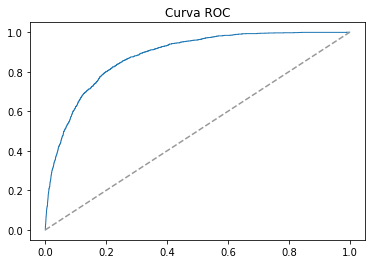

In [72]:
best_model_lgbm = LGBMClassifier(n_estimators=500, num_leaves=128, min_child_samples=7,
                              subsample=0.55, colsample_bytree=0.11, learning_rate=0.07, 
                              random_state=12)
    
best_model_lgbm.fit(X_train_3, y_train_3)
y1_predicted = best_model_lgbm.predict(X_test_encoded)
y1_predicted_prob = best_model_lgbm.predict_proba(X_test_encoded)[:, 1]
fpr, tpr, threshold = roc_curve(y_test.values, y1_predicted_prob)
roc_auc = roc_auc_score(y_test, y1_predicted_prob)

print(classification_report(y_test, y1_predicted, target_names=['no','yes']))
print('------')
print('Area sob a curva AUC: {:.03f}'.format(roc_auc))

plt.plot(fpr, tpr, lw=1)
#plot_roc_curve(best_model_s, X1_test_encoded, y1_test)
plt.plot([0,1],[0,1], '--', color=(0.6,0.6,0.6), label="sorte")
plt.title("Curva ROC", fontsize=12)

plt.show()

In [73]:
cnf_matrix = confusion_matrix(y_test, y1_predicted)
cnf_matrix

array([[11757,   220],
       [ 1170,   417]], dtype=int64)